# Importing Libraries

We'll be using __[spaCy](https://spacy.io/)__ for text processing and the named Natural Language Processing (NLP) recognition, __[NetworkX]()__ for analyzing the network and __[pyvis](https://pyvis.readthedocs.io/en/latest/)__ for network graph visualization.<br>
spaCy is a free open sourced library used for NLP. Another widely used library is __[Natural Language Toolkit (NLTK)](https://www.nltk.org/)__, which is more research focused, and it provides a lot of different algorithms, however spaCy uses mostly the best and the latest algorithms, so it often results in better performance.

In [1]:
import pandas as pd
import numpy as np
import spacy

# displacy module will be used to visualize some entities later.
from spacy import displacy
import networkx as nx

# For changing some plot settings later
import matplotlib.pyplot as plt

In [5]:
""" Importing the english language model for spaCy """
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
# Loading the spaCy English language model
NER = spacy.load('en_core_web_sm')

# Stratergy

There are several methods for extracting relationships from texts: from simple Rule-Based methods to advanced Deep Learning models. Deep Learning models, that are currently available, are often trained on a specific dataset, for eg: research papers on drug discoveries, so they're not really suitable for a fantasy novel. We're going to go for a simple baseline model that is based on Named Entity Recognition (click __[here](https://www.geeksforgeeks.org/named-entity-recognition/)__ for more info), together with some custom rules as follows:
1. First, we'll tokenize every book into a list of sentences and then label each sentence by the name of its character(s) appearing in the sentence.
![[Geralt, Nenneke] (1).png](attachment:a4c719e5-21e6-4916-b080-d271bd57bcdd.png)
2. Second, we'll define a window size of how far 2 sentences are apart from each other and assume that if 2 characters are mentioned in 2 sentences, within this window, then there is a relationship between them, with Named Entity Recognition. 
![[Geralt, Nenneke] (2).png](attachment:25530584-cf60-47a6-adbb-ff5c9a6f5894.png) <br>

Of course we'll recognize all kinds of entities from text: from a person's name to organization's name to location and so on. And the good thing is, we already know the names of all the characters from the books since we scraped them from the witcher wiki website using Selenium. So we can easily, automatically, filter out all the entitites that are not characters, such as names of the monsters or a kingdom.
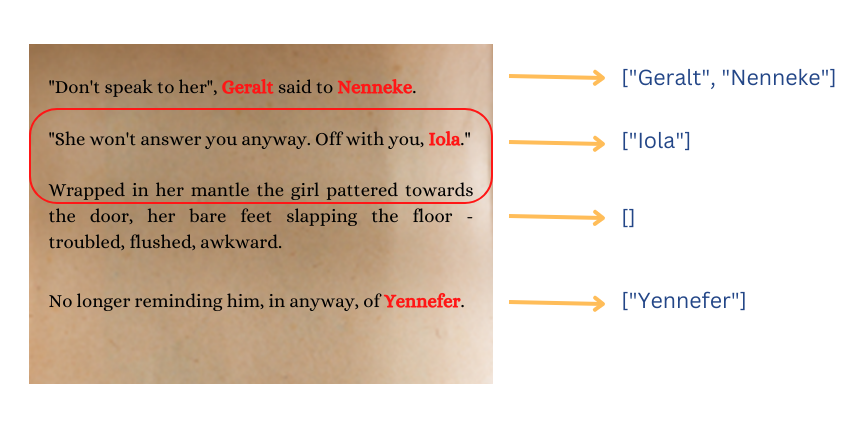
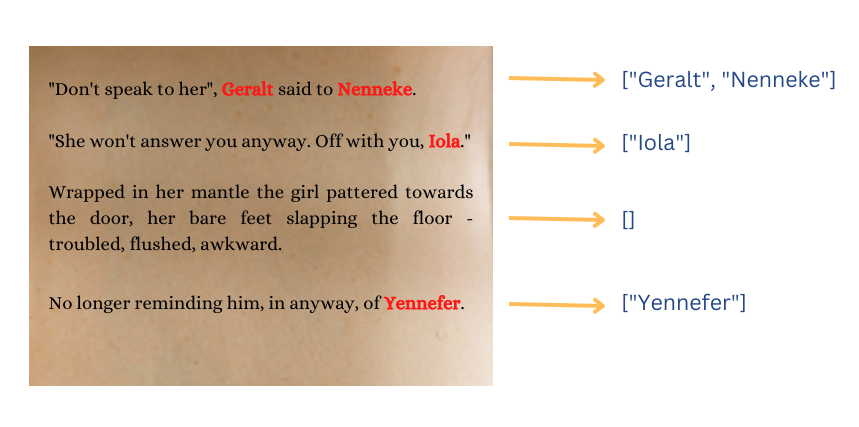

# Loading Books

In [7]:
import os

# Get all book files in the data directory.
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
all_books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 something ends something begins.txt'>]

# Picking the 1st book and doing analysis on it

In [8]:
book = all_books[1]

# Open and read the text found in this book.
book_text = open(book).read()

# Calling the Named Entity Recognition object.
book_doc = NER(book_text)

In [10]:
""" Visualizing the identified entities with displacy. 
    Doing this for the first 2000 characters of the book, since the book is very long. """
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

# Loading Characters Names

In [11]:
# Read characters.
character_df = pd.read_csv('characters.csv')
character_df

,Unnamed: 0,book,character
0,0,Category:Baptism of Fire characters,Adalia
1,1,Category:Baptism of Fire characters,Adela
2,2,Category:Baptism of Fire characters,Aen Saevherne
3,3,Category:Baptism of Fire characters,Aevenien
4,4,Category:Baptism of Fire characters,Aglaïs
...,...,...,...
1270,1270,Category:Time of Contempt characters,Yanna of Murivel
1271,1271,Category:Time of Contempt characters,Yarpen Zigrin
1272,1272,Category:Time of Contempt characters,Yennefer of Vengerberg
1273,1273,Category:Time of Contempt characters,Yiolenta Suarez


In [17]:
character_df.iloc[13, 2]

'Aubry (first born)'

In [18]:
character_df.iloc[27, 2]

'Cirilla Fiona (imposter)'

In [19]:
character_df.iloc[51, 2]

'Falka (alias)'

In [23]:
character_df.iloc[59, 2]

'Geralt of Rivia'

As we can see, there are some names in the characters dataset that have additional info in the brackets. We don't want them in our character names because later we will have to match those names with the names that are actually appearing in the books. So we're gonna remove the brackets and the text between them. <br>

We'll import the __[regular expression](https://docs.python.org/3/library/re.html)__ module and we'll do an __[apply](https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/)__ function on the 'character' column of our dataset. For each row in this column, we will substitute the pattern in the parenthesis of the first arguement with an empty string and if the pattern is not found, we'll simply return to the original value.

`character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))` <br>

We'll also create a column for the first names of the characters, because sometimes in a text, a character might be mentioned only by the first name. For eg: Geralt of Rivia, the hero in the series, is only mentioned as Geralt in the books. So we will do an __[apply](https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/)__ function on the character column, and we will use a lambda function to split the string into different words, and then we'll only take the first word, which is the first name of the characters.

`character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])`

In [24]:
# Remove brackets and text between them.
import re
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [25]:
# Checking the character_df to make sure everything works
pd.set_option('display.max_rows', None)
character_df

,Unnamed: 0,book,character,character_firstname
0,0,Category:Baptism of Fire characters,Adalia,Adalia
1,1,Category:Baptism of Fire characters,Adela,Adela
2,2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,4,Category:Baptism of Fire characters,Aglaïs,Aglaïs
5,5,Category:Baptism of Fire characters,Albrich,Albrich
6,6,Category:Baptism of Fire characters,Amavet,Amavet
7,7,Category:Baptism of Fire characters,Angus Bri Cri,Angus
8,8,Category:Baptism of Fire characters,Anna Kameny,Anna
9,9,Category:Baptism of Fire characters,Anzelm Aubry,Anzelm
